In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

Using GPU 0: GeForce RTX 2080 Ti
Driver: 418.56


In [3]:
train_loader = VisionDataset(vision.FashionMNIST, 128, normalize=True)

In [4]:
class ActiveNoise(nn.Module):
    def __init__(self, type='add', gain=2):
        super().__init__()
        self.gain = gain
        self.type = type
        
    def forward(self, x):
        if self.training:
            if self.type == 'add':
                return x + ((torch.Tensor(x.size()).uniform_().to(x.device) - 0.5) * self.gain)
            elif self.type == 'mul':
                return x * (torch.Tensor(x.size()).uniform_().to(x.device) * self.gain)
        return x

In [5]:
g = builder([
    nn.Linear(110, 8*4*4),
    nn.BatchNorm1d(8*4*4),
    nn.LeakyReLU(),
    layer.Reshape((-1, 8, 4, 4)),
    AutoConvTransposeNet2d(8, 3, 'vgg', start_filter=128, min_filter=128, preact=False, pooling_type='pixelshuffle', norm='batch'),
    nn.Conv2d(128, 1, 5),
    nn.Tanh(),
])  

8 128
128 128
128 128


In [6]:
d = builder([
    layer.ConditionProjection(
        builder([
            nn.Linear(10, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(),
            layer.Reshape((-1, 1, 28, 28)),
        ]),
        ActiveNoise(gain=0.5)
    ),
    AutoConvNet2d(2, 4, 'resnext', start_filter=128, max_filter=256, flatten=True, pooling_type='maxpool', preact=False, norm='batch'),
#     Auxiliary(builder([
#         nn.Linear(128, 10),
#         nn.LogSoftmax(-1)
#     ])),
    nn.Linear(256, 1),
    nn.Sigmoid()
])

2 128
128 256
256 256
256 256


In [11]:
runner = Runner(GANModel(g, d, latent_vector_len=100, condition_vector_len=[10, 10], condition_onehot=True),
                train_loader, 
                None, 
                'rmsprop', 
                GANLoss('vanilla'),
                monitor_state='g_loss',
                monitor_mode='min')

In [12]:
runner.init_model('lsuv')

In [13]:
runner.fit(4)

  Epochs   train_d_loss  train_g_loss 
    1*        2.5969        5.9149    


    2         1.1921        6.7399    


    3         2.2901        6.3833    


    4*        1.3524        4.7080    


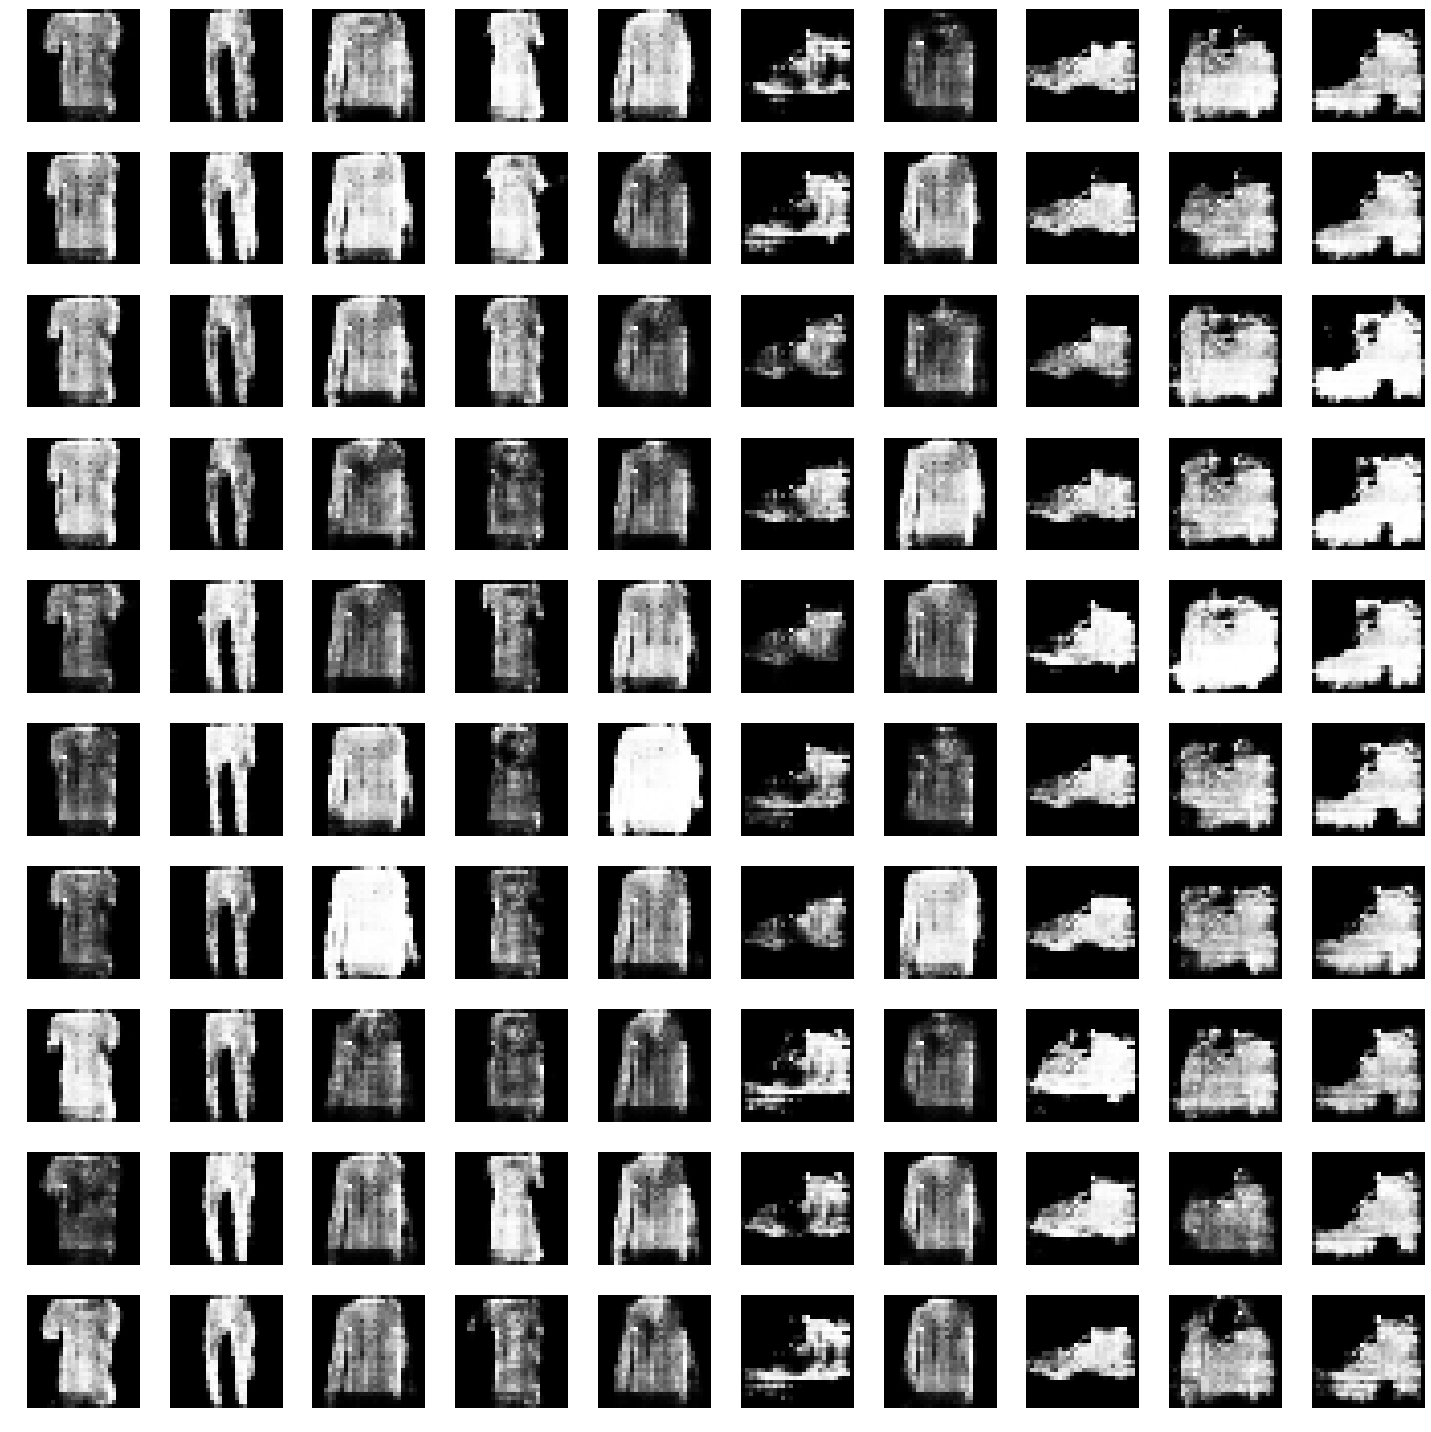

In [14]:
img = runner.model.sample(100, condition_data=list(range(10))*10)
import matplotlib.pyplot as plt
fig, arr = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    r = img[i][0].detach().cpu().numpy()#.transpose(1,2,0)
#     r -= r.min()
#     r /= r.max()
    arr[i//10][i%10].axis('off')
    arr[i//10][i%10].imshow(r, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
runner.report()